**Business Applications of Data Science - Project 2**


*Group 7 - Aadya Sood, Arvind Yadav, Gaurav Dixit, Radhika Swaroop, Yashasvee Singh*

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro, levene, ttest_ind, f_oneway, chi2_contingency, pearsonr
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load dataset
df = pd.read_excel("FMCG_Dataset.xlsx")

# Data Preprocessing and Exploration

In [ ]:
# Data cleaning
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Transaction_ID'], inplace=True)

In [ ]:
numeric_cols = ['Unit_Price', 'Units_Sold', 'Profit_Margin', 'Discount_Applied',
                'Marketing_Spend', 'Competitor_Price', 'Stock_Levels',
                'Supplier_Reliability', 'Total_Revenue', 'Profit']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Create binary target: High_Profit
df['High_Profit'] = (df['Profit'] > df['Profit'].median()).astype(int)

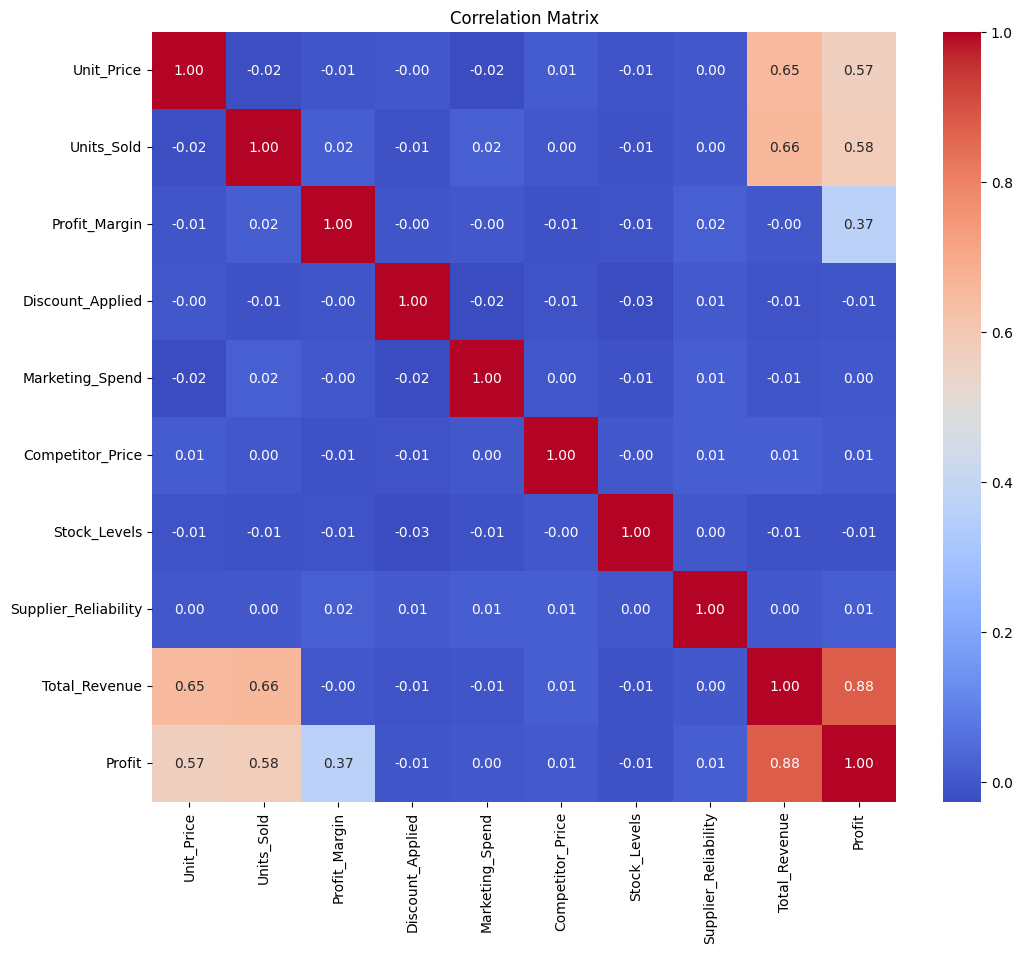

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

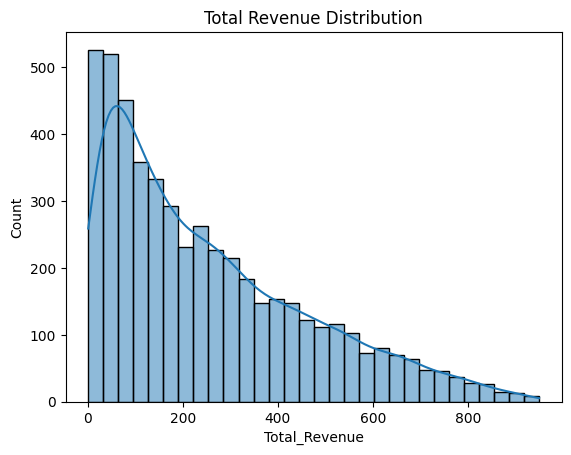

In [ ]:
# Distributions
sns.histplot(df['Total_Revenue'], bins=30, kde=True)
plt.title('Total Revenue Distribution')
plt.show()

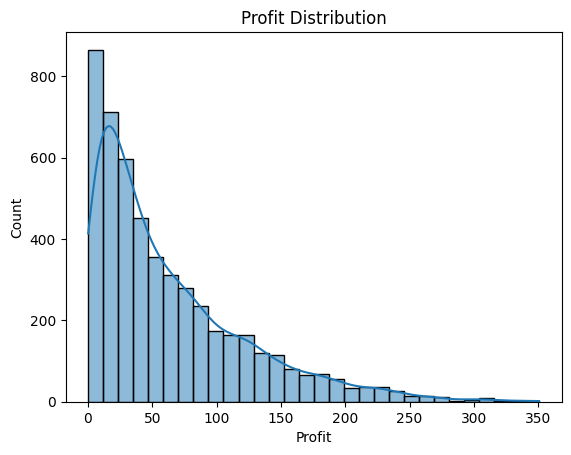

In [ ]:
sns.histplot(df['Profit'], bins=30, kde=True)
plt.title('Profit Distribution')
plt.show()

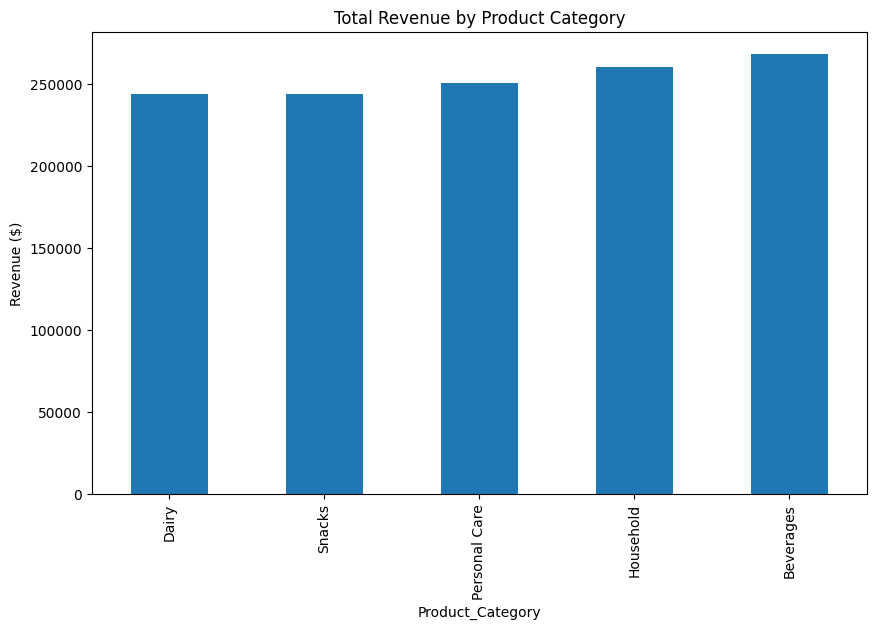

In [ ]:
# Revenue by Category
category_revenue = df.groupby('Product_Category')['Total_Revenue'].sum().sort_values()
category_revenue.plot(kind='bar', figsize=(10,6))
plt.title('Total Revenue by Product Category')
plt.ylabel('Revenue ($)')
plt.show()

# Hypothesis Testing

# Hypothesis 1

Hypothesis 1: High Discounts Increase Units Sold

Null (H0): Mean Units Sold is the same for high vs. low discounts.

Alternative (H1): High discounts increase Units Sold.

Test: T-test (assuming normality, else use Mann-Whitney U).



In [ ]:
# Hypothesis Test 1: Does discount level affect units sold?
high_discount = df[df['Discount_Applied'] > df['Discount_Applied'].median()]['Units_Sold']
low_discount = df[df['Discount_Applied'] <= df['Discount_Applied'].median()]['Units_Sold']
t_stat, p_val = ttest_ind(high_discount, low_discount, alternative='greater')
print(f"T-test: t={t_stat:.4f}, p={p_val:.4f}")
print("Conclusion:", "High discounts increase Units Sold" if p_val < 0.05 else "No significant difference")

T-test: t=-1.1490, p=0.8747
Conclusion: No significant difference


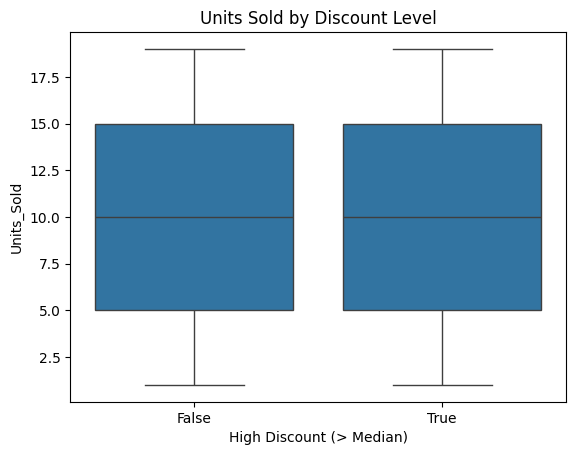

In [ ]:
# Boxplot for discount vs units sold
sns.boxplot(x=df['Discount_Applied'] > df['Discount_Applied'].median(), y='Units_Sold', data=df)
plt.title('Units Sold by Discount Level')
plt.xlabel('High Discount (> Median)')
plt.show()


# Hypothesis 2

Hypothesis 2: Online Sales Have Higher Revenue than Offline Sales

Null (H0): Mean Total Revenue is the same for Online and Offline.

Alternative (H1): Online has higher Revenue.

Test: T-test.



In [ ]:
# Hypothesis Test 2: Online vs Offline revenue
online_revenue = df[df['Sales_Channel'] == 'Online']['Total_Revenue']
offline_revenue = df[df['Sales_Channel'] == 'Offline']['Total_Revenue']
t_stat, p_val = ttest_ind(online_revenue, offline_revenue, alternative='greater')
print(f"T-test (Online vs Offline Revenue): t={t_stat:.4f}, p={p_val:.4f}")
print("Conclusion:", "Online sales generate more revenue" if p_val < 0.05 else "No significant difference")

T-test (Online vs Offline Revenue): t=0.7244, p=0.2344
Conclusion: No significant difference


# Hypothesis 3

Hypothesis 3: Supplier Reliability Impacts Stock Levels

Null (H0): No correlation between Supplier Reliability and Stock Levels.

Alternative (H1): Positive correlation exists

Test: Pearson correlation.



Pearson correlation: r=0.00, p=0.9148
Conclusion: No significant relationship


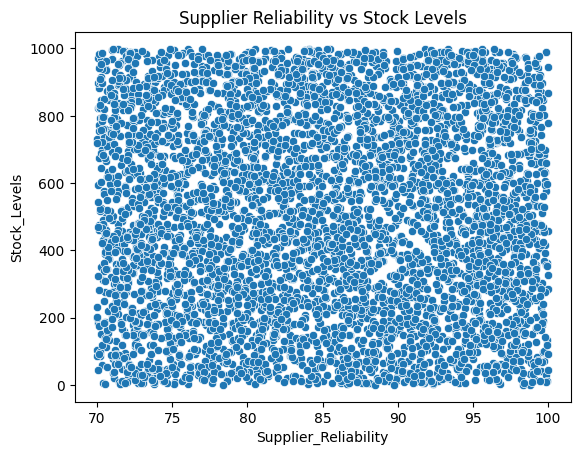

In [ ]:
# Pearson correlation between Supplier Reliability and Stock Levels
corr, p_val = pearsonr(df['Supplier_Reliability'], df['Stock_Levels'])
print(f"Pearson correlation: r={corr:.2f}, p={p_val:.4f}")
print("Conclusion:", "Significant relationship" if p_val < 0.05 else "No significant relationship")
sns.scatterplot(x='Supplier_Reliability', y='Stock_Levels', data=df)
plt.title("Supplier Reliability vs Stock Levels")
plt.show()

# Hypothesis 4

Hypothesis 4: Age Groups Differ in Profit Contribution

Null (H0): Mean Profit is the same across Age Groups.

Alternative (H1): Profit differs by Age Group

Test: ANOVA.


In [ ]:
# Hypothesis 4: Does profit differ by customer age group?

# Assumption 1: Homogeneity of variances (Levene's test)
groups = [group['Profit'] for name, group in df.groupby('Customer_Age_Group')]
levene_stat, p_levene = levene(*groups)
print(f"Levene's Test: Stat={levene_stat:.4f}, p={p_levene:.4f}")
print("Variances are homogeneous" if p_levene > 0.05 else "Variances are NOT homogeneous")

Levene's Test: Stat=1.7960, p=0.1267
→ Variances are homogeneous


In [ ]:
# Assumption 2: Normality within each group (Shapiro-Wilk)
print("\nShapiro-Wilk Test for Normality by Age Group:")
for name, group in df.groupby('Customer_Age_Group'):
    stat, p = shapiro(group['Profit'])
    print(f"{name}: Stat={stat:.4f}, p={p:.4f} →", "Normal" if p > 0.05 else "Not normal")


Shapiro-Wilk Test for Normality by Age Group:
18-25: Stat=0.8612, p=0.0000 → Not normal
26-35: Stat=0.8552, p=0.0000 → Not normal
36-45: Stat=0.8546, p=0.0000 → Not normal
46-60: Stat=0.8432, p=0.0000 → Not normal
60+: Stat=0.8625, p=0.0000 → Not normal


In [ ]:
# Perform one-way ANOVA
f_stat, p_val = f_oneway(*groups)
print(f"\nANOVA Result: F={f_stat:.4f}, p={p_val:.4f}")
print("Conclusion:", "Profit differs by Age Group" if p_val < 0.05 else "No significant difference")


ANOVA Result: F=0.6452, p=0.6302
Conclusion: No significant difference


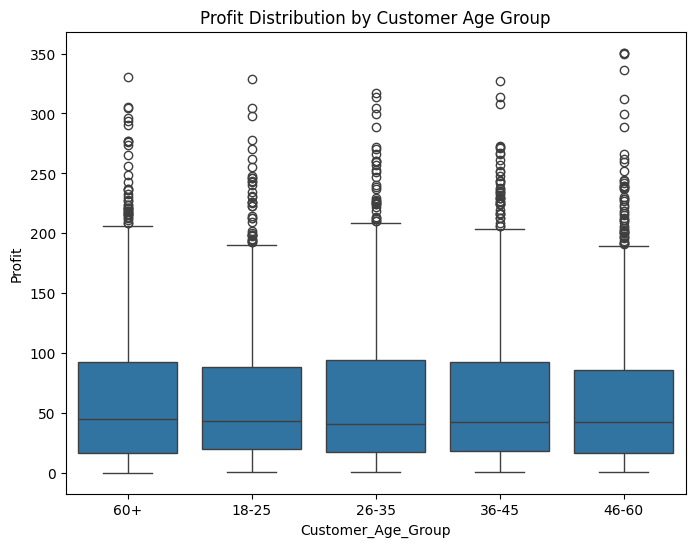

In [ ]:
# Boxplot visualization
plt.figure(figsize=(8,6))
sns.boxplot(x='Customer_Age_Group', y='Profit', data=df)
plt.title("Profit Distribution by Customer Age Group")
plt.show()

# Hypothesis 5

Hypothesis 5: Profit Margin Impacts Profit Significantly

Null (H0): Profit_Margin has no effect on Profit (slope = 0).

Alternative (H1): Profit_Margin has a positive effect on Profit (slope > 0).

Test: Simple linear regression (to confirm the relationship and its significance).

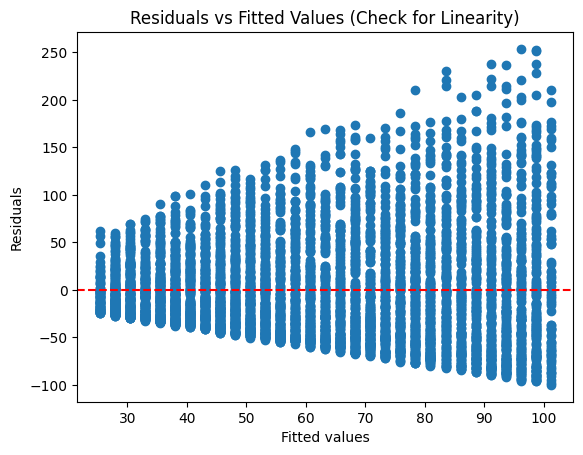

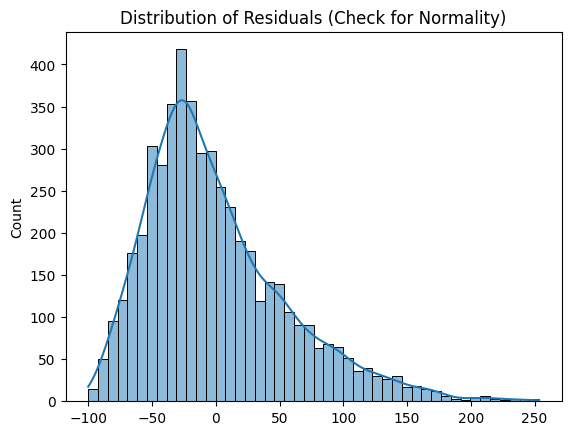

Shapiro-Wilk Test for Residual Normality: ShapiroResult(statistic=np.float64(0.9345117732676043), pvalue=np.float64(2.3567596133274983e-42))
Breusch-Pagan test: p=0.0000 → Heteroscedastic
Durbin-Watson Statistic: 2.0218 → No autocorrelation


In [ ]:
# ASSUMPTIONS CHECKS FOR LINEAR REGRESSION

# Residuals
residuals = model.resid

# 1. Linearity: Residuals vs Fitted
plt.scatter(model.fittedvalues, residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (Check for Linearity)")
plt.show()

# 2. Normality of residuals
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals (Check for Normality)")
plt.show()
print("Shapiro-Wilk Test for Residual Normality:", shapiro(residuals))

# 3. Homoscedasticity: Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_const)
print(f"Breusch-Pagan test: p={bp_test[1]:.4f} →", "Homoscedastic" if bp_test[1] > 0.05 else "Heteroscedastic")

# 4. Independence of residuals: Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.4f} →", "No autocorrelation" if 1.5 < dw_stat < 2.5 else "Possible autocorrelation")

In [ ]:
# Simple Linear Regression: Profit ~ Profit Margin

X = df['Profit_Margin']
y = df['Profit']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     777.3
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          4.09e-159
Time:                        13:58:11   Log-Likelihood:                -27155.
No. Observations:                5000   AIC:                         5.431e+04
Df Residuals:                    4998   BIC:                         5.433e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1507      2.384      0.063

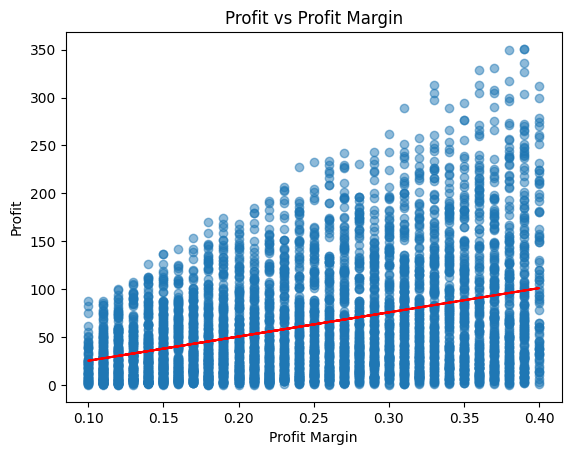

In [ ]:
# Plot with regression line
plt.scatter(X, y, alpha=0.5)
plt.plot(X, model.predict(X_const), color='red')
plt.xlabel('Profit Margin')
plt.ylabel('Profit')
plt.title('Profit vs Profit Margin')
plt.show()

# Hypothesis 6

Hypothesis 6: High-Profit Transactions Are More Likely in Certain Sales Channels


Null (H0): Sales_Channel has no effect on the likelihood of a High_Profit transaction.

Alternative (H1): Sales_Channel affects the likelihood of a High_Profit transaction.

Test: Chi-Square Test of Independence (since High_Profit is likely categorical and Sales_Channel is categorical).


Chi-Square Statistic: 0.23122500929700557, P-value: 0.6306169865372881


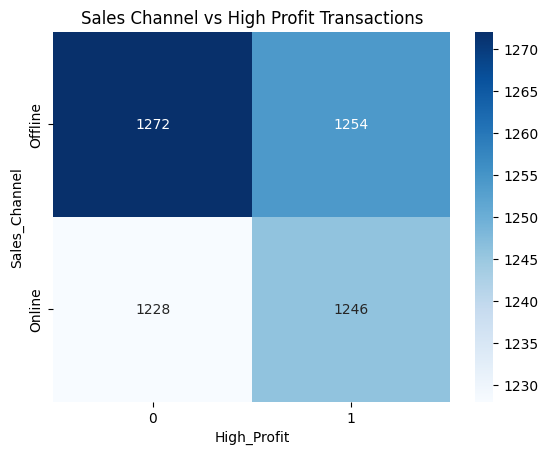

In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['Sales_Channel'], df['High_Profit'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-value: {p}")

# Visualize the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Sales Channel vs High Profit Transactions')
plt.show()

# Hypothesis 7

Hypothesis 7: Higher Unit Prices Lead to Higher Total Revenue

Null (H0): There is no relationship between Unit_Price and Total_Revenue (slope = 0 in a regression model).

Alternative (H1): There is a positive relationship between Unit_Price and Total_Revenue (slope > 0).

Test: Simple Linear Regression (to confirm the relationship and its significance).

                            OLS Regression Results                            
Dep. Variable:          Total_Revenue   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     3644.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:13:20   Log-Likelihood:                -32488.
No. Observations:                5000   AIC:                         6.498e+04
Df Residuals:                    4998   BIC:                         6.499e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6790      4.687      1.212      0.2

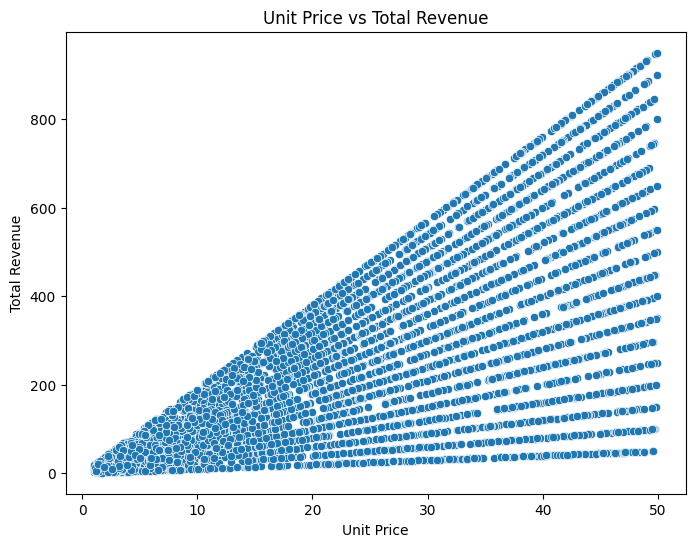

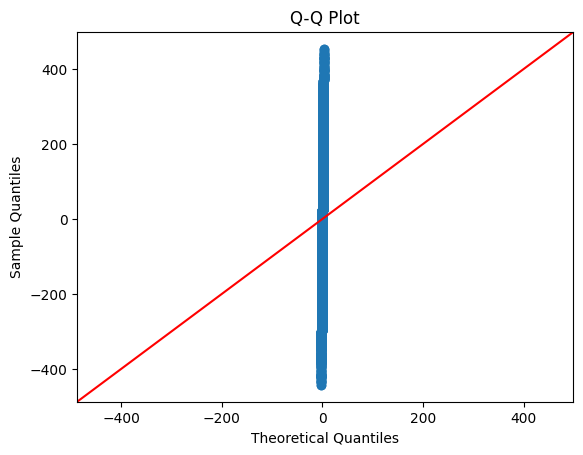

Durbin-Watson statistic: 1.9910632748327837
Residuals are likely independent.
Breusch-Pagan p-value: 0.0
Shapiro-Wilk Test p-value: 2.0657847559643495e-15

Variance Inflation Factors (VIF):
     Variable       VIF
0       const  4.257892
1  Unit_Price  1.000000
No significant multicollinearity detected.


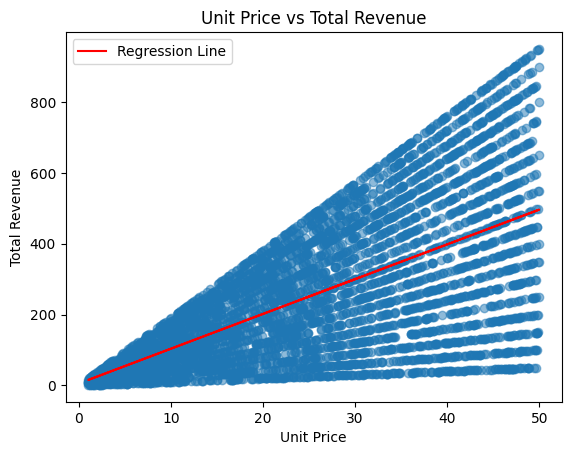

In [ ]:
# Define independent (X) and dependent (y) variables
X = df['Unit_Price']
y = df['Total_Revenue']
X = sm.add_constant(X)  # Add constant for intercept

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

# Assumption Checks

## 1. Linearity - Scatter plot for Unit Price vs Total Revenue
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Unit_Price'], y=df['Total_Revenue'])
plt.title('Unit Price vs Total Revenue')
plt.xlabel('Unit Price')
plt.ylabel('Total Revenue')
plt.show()

# Q-Q plot for residuals to check normality
sm.qqplot(model.resid, line='45')
plt.title("Q-Q Plot")
plt.show()

## 2. Independence of Errors - Durbin-Watson Test
dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_stat}')
if dw_stat < 1.5 or dw_stat > 2.5:
    print("Warning: Possible autocorrelation in the residuals (non-independence of errors).")
else:
    print("Residuals are likely independent.")

## 3. Homoscedasticity - Breusch-Pagan Test
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_p_value = bp_test[1]
print(f'Breusch-Pagan p-value: {bp_p_value}')
if bp_p_value < 0.05:
    print("Warning: Heteroscedasticity detected (non-constant variance of errors).")
else:
    print("Residuals have constant variance (no heteroscedasticity).")

## 4. Normality of Errors - Shapiro-Wilk Test (Alternative to Q-Q plot)
shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
print(f'Shapiro-Wilk Test p-value: {shapiro_p_value}')
if shapiro_p_value < 0.05:
    print("Warning: Residuals are not normally distributed.")
else:
    print("Residuals appear to be normally distributed.")

## 5. Multicollinearity - Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors (VIF):")
print(vif_data)
if any(vif_data["VIF"] > 10):
    print("Warning: Multicollinearity detected (VIF > 10).")
else:
    print("No significant multicollinearity detected.")

# Plot the relationship
plt.scatter(df['Unit_Price'], df['Total_Revenue'], alpha=0.5)
plt.plot(df['Unit_Price'], model.predict(X), color='red', label='Regression Line')
plt.xlabel('Unit Price')
plt.ylabel('Total Revenue')
plt.title('Unit Price vs Total Revenue')
plt.legend()
plt.show()

# Predictive Model

Revenue Drivers (Multiple Linear Regression)

In [ ]:
# MULTIPLE LINEAR REGRESSION: Predict Revenue from Features

features = ['Unit_Price', 'Units_Sold', 'Discount_Applied', 'Marketing_Spend', 'Competitor_Price']
X = df[features]
y = df['Total_Revenue']

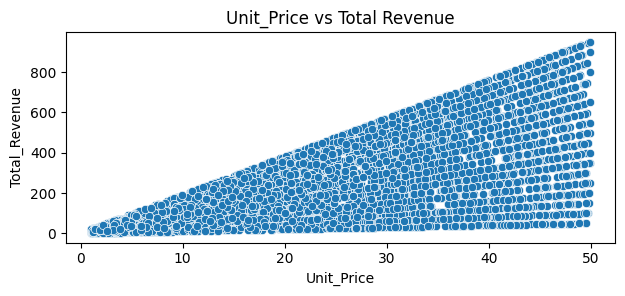

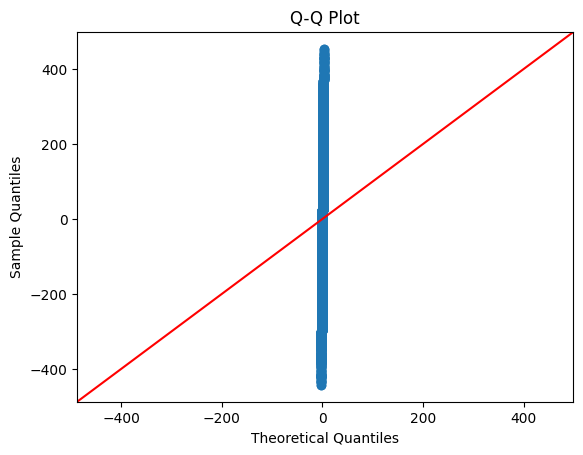

Durbin-Watson statistic: 1.9910632748327837
Residuals are likely independent.
Breusch-Pagan p-value: 0.0
Shapiro-Wilk Test p-value: 2.0657847559643495e-15

Variance Inflation Factors (VIF):
     Variable       VIF
0       const  4.257892
1  Unit_Price  1.000000
No significant multicollinearity detected.


In [ ]:
## 1. Linearity - Scatter plots for each predictor vs. target variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(X.columns[1:], 1):  # Skip the constant term (first column)
    plt.subplot(3, 2, i)
    sns.scatterplot(x=X[col], y=y)
    plt.title(f'{col} vs Total Revenue')
plt.tight_layout()
plt.show()

# Q-Q plot for residuals to check normality
sm.qqplot(model.resid, line='45')
plt.title("Q-Q Plot")
plt.show()

## 2. Independence of Errors - Durbin-Watson Test
dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_stat}')
if dw_stat < 1.5 or dw_stat > 2.5:
    print("Warning: Possible autocorrelation in the residuals (non-independence of errors).")
else:
    print("Residuals are likely independent.")

## 3. Homoscedasticity - Breusch-Pagan Test
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_p_value = bp_test[1]
print(f'Breusch-Pagan p-value: {bp_p_value}')
if bp_p_value < 0.05:
    print("Warning: Heteroscedasticity detected (non-constant variance of errors).")
else:
    print("Residuals have constant variance (no heteroscedasticity).")

## 4. Normality of Errors - Shapiro-Wilk Test (Alternative to Q-Q plot)
shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
print(f'Shapiro-Wilk Test p-value: {shapiro_p_value}')
if shapiro_p_value < 0.05:
    print("Warning: Residuals are not normally distributed.")
else:
    print("Residuals appear to be normally distributed.")

## 5. Multicollinearity - Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors (VIF):")
print(vif_data)
if any(vif_data["VIF"] > 10):
    print("Warning: Multicollinearity detected (VIF > 10).")
else:
    print("No significant multicollinearity detected.")

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Evaluation
print(f"\nR² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


R² Score: 0.8742
RMSE: 73.84


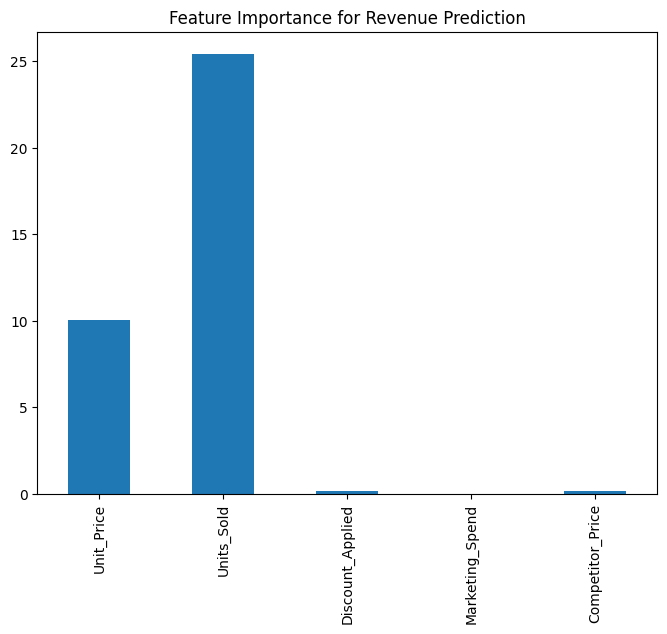

In [ ]:
# Feature importance
coef = pd.Series(model.coef_, index=features)
coef.plot(kind='bar', figsize=(8,6), title="Feature Importance for Revenue Prediction")
plt.show()

In [ ]:
# Final model with statsmodels for summary
X_stats = sm.add_constant(X)
model = sm.OLS(y, X_stats).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Total_Revenue   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     6514.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:59:51   Log-Likelihood:                -28813.
No. Observations:                5000   AIC:                         5.764e+04
Df Residuals:                    4994   BIC:                         5.768e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -258.4728      4.547  

Revenue is primarliy driven by Units Sold (directly contributes to Revenue), Marketing Spend (likely increases awareness/sales), Discount Applied may reduce revenue per item but could indirectly increase volume.
Competitor Price and Unit Price may show limited direct impact, suggesting market demand could be less price-sensitive, or price effects are mediated by marketing and discounts.


# Hypothesis Testing Insights

1. High Discounts Increase Units Sold

Conclusion: No significant difference, discounts did not significantly increase the number of units sold.
Recommendation: Re-evaluate the discount strategies, consider A/B testing different pricing levels before large-scale discounting.

2. Online Sales Generate Higher Revenue Than Offline

Conclusion: No significant difference, online and offline sales channels generate similar revenue on average.
Recommendation: Maintain a balanced omnichannel strategy rather than prioritizing one over the other.

3. Supplier Reliability and Stock Levels

Conclusion: No relationship found, Supplier reliability is not linked to inventory levels.
Recommendation: Investigate other factors affecting inventory (e.g internal stock planning or demand variability).

4. Does Profit DIffer by Customer Age Group?

Conclusion: No significant difference, all age groups contribute similarly to profit.
Recommendation: Avoid age-based targeting for profit optimization, explore segmentation by behavior, geography, or purchase history instead.


5. Profit Margin and Profit: There are positively correlated.


Recommendation: Focus on improving profit margins via cost control, premium pricing and efficiency. Since the assumptions are violated, use robust standard errors or try log-transforming variables for better model reliability.

6. High-Profit Transactions Are More Likely in Certain Sales Channels

Conclusion: There is no statistically significant association between Sales Channel (Online vs. Offline) and High Profit (whether a transaction is categorized as high-profit based on profit margin).

In other words, the sales channel (whether a sale is made online or offline) does not have a significant impact on whether a transaction results in a high profit.

7. Revenue and Unit Price: Higher unit prices are associated with significantly higher revenue.


Recommendation: For producrs where price increases don't reduce volume, consider strategic price adjustments. Pair pricing strategy with value communication and bundling to justify increased prices.

# Overall Business Recommendations:



*   Don't assume discounts automatically increase sales - test and validate strategies using data.

*   Treat both online and offline sales equally in budget and focus - neither dominates revenue.

* Investigate other drivers of stock levels, supplier reliability may not be the key factor.

* Avoid age-based targeting for profit - consider behavioral or transactional segmentation instead.

* Focus on profit margin improvement - it is positively associated with higher profit.

* Use pricing power wisely - increases in unit price can strongly boost revenue when demand allows.

* Use robust or transformed models when assumptions are violated to improve prediction reliability.

* Either channel (online or offline) can be used to make business profitable.
